<a href="https://colab.research.google.com/github/subhdeepkaur/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [ ]:
# put your imports here

In [17]:
import numpy as np
import networkx as nx
import random
from collections import deque
import matplotlib.pyplot as plt

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


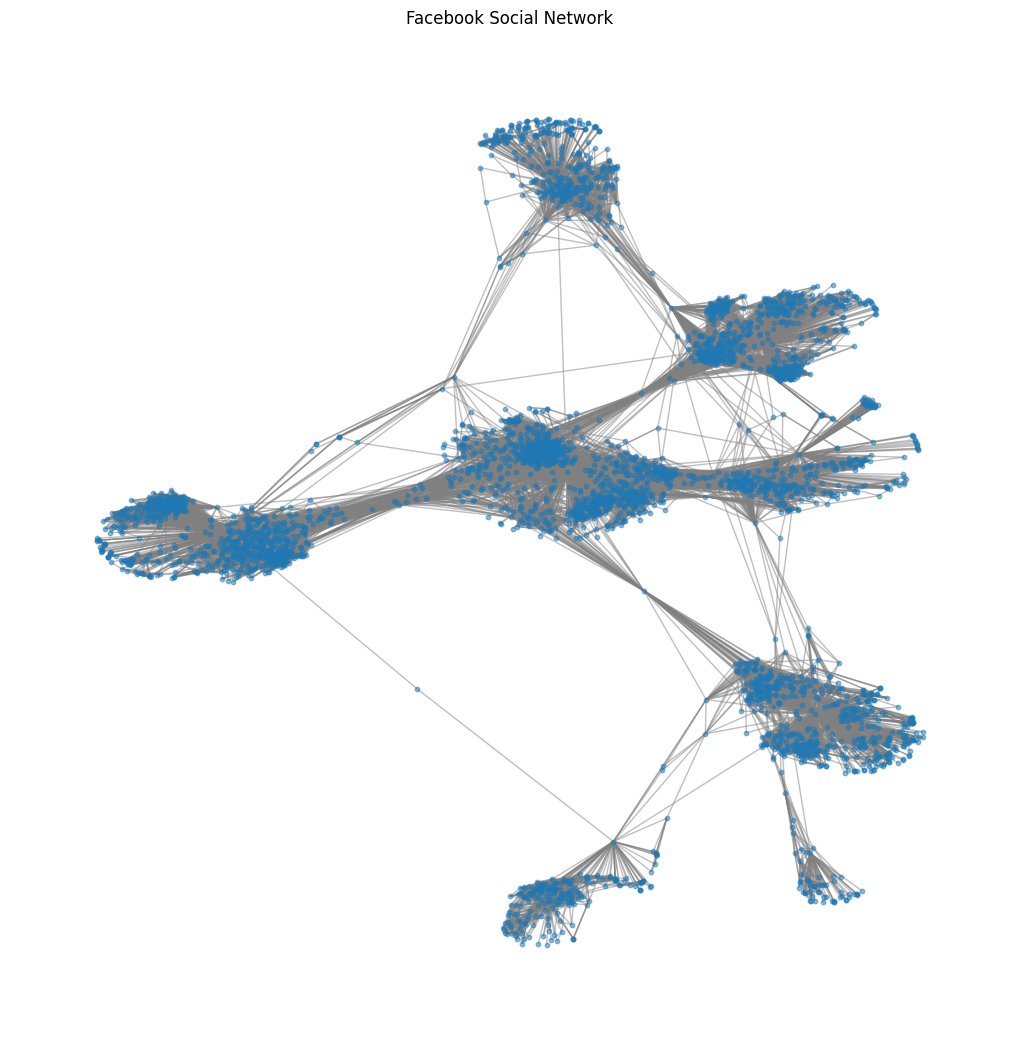

In [19]:
# Ex 1 code here
def load_facebook_graph(file_path):
    """Reads an edge list from a file and returns a NetworkX graph."""
    G = nx.Graph()
    edges = np.loadtxt(file_path, dtype=int)    #load all edges using numpy's loadtxt function
    G.add_edges_from(edges)
    return G

file_path = "facebook_combined.txt"  # Ensure this file is in the correct location
G = load_facebook_graph(file_path)

assert(G.number_of_nodes()) == 4039
assert(G.number_of_edges()) == 88234

# Load the Facebook graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.5)
plt.title("Facebook Social Network")
plt.show()

## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [24]:
# Ex 2 code here
def sample_average_clustering(G, N=1000):
  nodes = list(G.nodes())

  # Ensure sample size doesn't exceed number of nodes
  sample_size = min(N, len(nodes))

  sampled_nodes = random.sample(nodes, sample_size)  # Randomly select N nodes
  clustering_values = [nx.clustering(G, node) for node in sampled_nodes]  # Compute clustering for sampled nodes

  return np.nanmean(clustering_values)

estimated_clustering = sample_average_clustering(G, N=500)
true_clustering = nx.average_clustering(G)
print(f"Estimated Clustering Coefficient: {estimated_clustering:.4f}")
print(f"True Clustering Coefficient: {true_clustering:.4f}")
print(f"Difference: {abs(estimated_clustering - true_clustering):.4f}")

Estimated Clustering Coefficient: 0.5988
True Clustering Coefficient: 0.6055
Difference: 0.0068


## Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [26]:
# Ex 3 code here
def average_shortest_path_length(G):
  shortest_path_lengths = []

  for node in G.nodes():
      path_lengths = nx.single_source_dijkstra_path_length(G, node)  # Compute shortest paths from `node`
      shortest_path_lengths.extend(path_lengths.values())  # Store all path lengths

  return np.mean(shortest_path_lengths)  # Compute average path length

avg_path_length = average_shortest_path_length(G)
print(f"Average Shortest Path Length: {avg_path_length:.4f}")



nx_avg_path_length = nx.average_shortest_path_length(G)

print(f"Custom Function Average Shortest Path Length: {avg_path_length:.4f}")
print(f"NetworkX Average Shortest Path Length: {nx_avg_path_length:.4f}")
print(f"Difference: {abs(custom_avg_path_length - nx_avg_path_length):.4f}")

Average Shortest Path Length: 3.6916
Custom Function Average Shortest Path Length: 3.6916
NetworkX Average Shortest Path Length: 3.6925
Difference: 0.0009


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [27]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

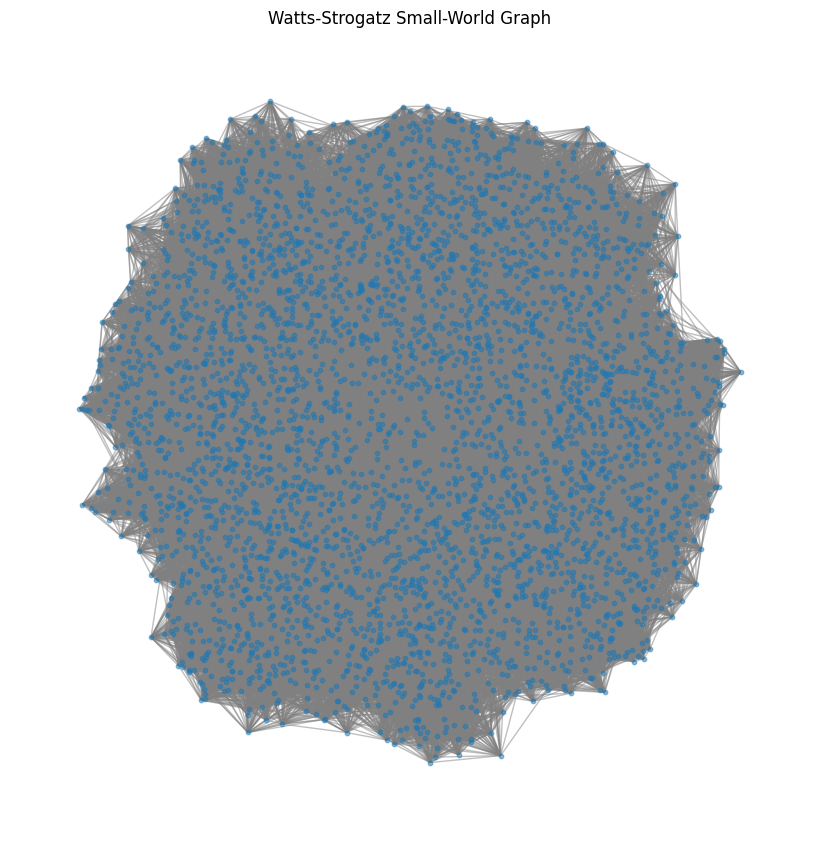

In [33]:
# Ex 4 code here

def make_ws_graph(n=4039, k=44, p=0.1):
  G = nx.watts_strogatz_graph(n, k, p)  # Create the WS graph
  return G

G_ws = make_ws_graph()
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_ws, seed=42)  # Spring layout for better visualization
nx.draw(G_ws, pos, node_size=10, edge_color="gray", alpha=0.5)
plt.title("Watts-Strogatz Small-World Graph")
plt.show()
